<center>
<h1><br/></h1>
<h1>INF581A: Advanced Deep Learning</h1>
<h2>Lab 5: Transformer and Transfer Learning</h2>

<h5>Tuesday, February 04, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit to Moodle a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>February 11
, 2025 11:59 AM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>

<h3><b>1. Introduction:</b></h2>
<p style="text-align: justify;">
Transfer learning that is, solving tasks with models that have been pretrained on very large amounts of data, was a game changer in many deep learning tasks. In NLP, while annotated data are scarce, raw text is virtually unlimited and readily available. Thus, the ability to learn good representations from plain text could greatly improve general natural language understanding. Learning without labels is enabled via self-supervised learning, a setting in which a system learns to predict part of its input from other parts of its input.

<p>One way to realise this pre-training is to use <i>generative pre-training</i> <a href="https://www.cs.ubc.ca/~amuham01/LING530/papers/radford2018improving.pdf" target='_blank'>[1]</a> of a language model. In this pre-training phase, the model will learn to predict the next tokens in a sequence given the previous ones.</p>
<p>Thus, this phase does not require any type of annotations apart from the input text itself. Once the language model is sufficiently pre-trained, it can be fine-tuned on supervised tasks while requiring minimal changes to its architecture (replacing the classification head).</p>

In this lab we will:
<ul>
    <li>Implement and pretrain a language model with transformer architecture.</li>
    <li>Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.</li>
    <li>Compare the performance of the pretrained model to a model trained from scratch.</li>
</ul>

<h3><b>2. The Model:</b></h3>
<p style="text-align: justify;">

Our model is based on Transformers<a href="https://arxiv.org/abs/1706.03762" target='_blank'>[2]</a>. While the Transformer is a model that follows the encoder-decoder structure, it is possible to use only the encoder part (as in BERT) or the decoder part (as in gpt) to perform some specific tasks. In this notebook, we use a multi-layer Transformer decoder for the language model. Fortunatly, PyTorch recent releases include a standard transformer blocks that can be easily used and adapted.

Let's start by implementing the model. The different layers used in this model are the following:

- The embedding layer
- Positional Embedding
- The transformer layers
- Linear layer for decoding and classification
<center>
<img src='https://am3pap003files.storage.live.com/y4m6sN7mGXA8_lmRiUuuAAbecrSrMa1IumytUCiEJEkIKuoKV2uNoqTmo6mU_PadFeMESJTRjNbM3Q9qIRMiXLMxPDBdKKFC5cX5UFslx44IxVGXBAI7Cipp5A38tVQdwrioDNyWAMIbYb7dQTXoa0T6oRDBl1kgGn2D9JV8wuna3Jhrsd3TgPQNZZnoO9ZpmaN?width=815&height=680&cropmode=none' alt="Drawing" width= '500px'/>

The same model can be used for language modeling and classification by just replacing the last layer in the model. This is why we split our model into two modules:

- base module: which consists of the 3 first layers.
- classifier module: which consists of the last layer.

After the pretraining, the parameters of the base model can be "transferred" to the model used in the classfication task, while the classifier module should be replaced by a new head initialized randomly.

Some of the code is adapted from this nice tutorial: <a href="https://pytorch.org/tutorials/beginner/transformer_tutorial.html" target="_blank">https://pytorch.org/tutorials/beginner/transformer_tutorial.html</a>



In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
Fill in the gaps in the `TransformerModel()` class to implement the described model.
<hr style="border:10px solid blue"> </hr>
</font></h4>

### The Model

In [34]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=nhid,
            nhead=nhead,
            dim_feedforward=nhid,  # Typically 4 times the model dimension
            dropout=dropout
        )
        #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)  # Add positional encoding
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)  # Base Transformer model
        self.classifier = ClassificationHead(nhid, nclasses)
    def forward(self, src, src_mask):
        # base model

        x = self.base(src, src_mask)
        #x = x.mean(dim=0)
        #fill me
        # classifier model
        output = self.classifier(x)
        return output

In [25]:
class PositionalEncoding(nn.Module):
  # for a more in depth explanation we encourage you to read:
  # https://medium.com/swlh/elegant-intuitions-behind-positional-encodings-dc48b4a4a5d1
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1 (4 points): </b><br>
What is the role of the square mask in our implementation? What about the positional encoding?
<hr style="border:10px solid red"> </hr>
</font></h4>








<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 1: </b><br>
Your answer here

In tasks like language modeling, where the model predicts the next token in a sequence, we must prevent the model from "cheating" by looking ahead at future tokens.
This mask ensures that, at each step, the model only attends to past and current tokens, not future tokens.

Unlike RNNs, Transformers do not have inherent sequence order awareness.
The self-attention mechanism treats all tokens simultaneously, meaning it doesn’t know which word comes first, second, etc. We add unique positional encodings to each token's embedding.
<hr style="border:10px solid green"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2 (2 points): </b><br>
Why do we have to replace the classification head? What is the main difference between the <i>language modeling</i> and the <i>classification</i> tasks?
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 2: </b><br>
Your answer here

We replace the classification head because language modeling and classification have different objectives. In language modeling, the model predicts the next word in a sequence, with the final layer mapping hidden states to vocabulary logits (ntoken). In classification, the model processes the entire text and predicts a category, so the final layer maps hidden states to class logits (nclasses).

The key difference is in handling output features: language modeling uses the last token's representation, while classification applies mean pooling over all tokens to obtain a single feature vector. This ensures the model captures the full context before making a final prediction.

<hr style="border:10px solid green"> </hr>
</font></h4>



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3 (6 points): </b><br>
How many trainable parameters does the model have in the case of <br>
<ul>
<font color='red'>
    <li><i>language modeling</i> task.</li>
    <li><i>classification</i> task.</li>
</ul>
Please detail your answer. You can omit the biases and the parameters of normalization layers.<br>
<hr style="border:10px solid red"> </hr>
</font></h4>



<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 3: </b><br>
Your answer here


Let's verify if our model works, by applying one inference step

In [26]:
ntokens = 100  # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


## 3.Vocabulary and Tokenization

To train the language model, the text in our corpus should be first tokenized. We use sentencepiece <a href="https://github.com/google/sentencepiece">https://github.com/google/sentencepiece</a> that implements byte-pair-encoding (BPE), a sub-word tokenization algorithm.<br>
The vocabulay is given in <code>dict.txt</code> file. Let's load it, and map each token to a unique index.<br>

In our experiments we use datasets that are already tokenized.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Fill in the gaps to create a <code>token2ind</code> and <code>ind2token</code> mapping dictionaries
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [8]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2025-02-10 19:49:00--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.04s   

2025-02-10 19:49:01 (15.3 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [10]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3}  # First 4 indices are reserved

with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()  # Extract the first word from each line
        token2ind[word] = idx + 4  # Assign an index starting from 4

# Creating the reverse mapping
ind2token = {v: k for k, v in token2ind.items()}

# Printing the word at index 1111
print(ind2token[1111])

▁trop


## 4.Data Loader
We use the <code>DataLoader</code> class, to load our dataset and generate the mini-batches used in the training. <code>get_loader()</code> returns a <code>DataLoader</code>  object, which is an iterable over data samples. The data loader can return mini-batches for language modeling or sequence classification based on the <code>task</code> argument that we pass to <code>get_loader()</code> function. Currently the function supports <i>language_modeling</i> and <i>classification</i> tasks.<br>

For the <i>language_modeling</i> task, both the input and the target are batches of sequences. In fact, the target is basically a shifted version of
the input, in such a way that each token is predicted given all previous tokens. For example, for a sequence A B C D: <br>
<b>Input:</b><code>\<sos\></code>A B C D<br>
<b>Output:</b>A B C D<code>\<eos\></code><br>

For the <i>classification</i> task,
the input is a batch of sequences and
the target is a batch of scalar labels.<br>
For more information about data loaders check: <a href="https://pytorch.org/docs/stable/data.html">https://pytorch.org/docs/stable/data.html</a>


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill in the gap inside <code>Dataset</code> class in order to create the input sequence
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [11]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind.get("<sos>", 3)] + [
            self.token2ind.get(token, self.token2ind.get("<oov>", 3)) for token in sequence
        ]

        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## 5.The Training
In this section we will implement a <code>train()</code> function that trains our model for one epoch. As we said, in this lab we will use a language modeling objective in
the pretraining phase. Given the previous tokens in a sequence,
the model will try to predict
the next one. The same function can be used for both pretraining and fine-tuning phase.<br>

The training procedure is as follows:<br>
1. Iterate over the data-loader.<br>
2. In each iteration perform one forward pass.<br>
3. Compute
the loss through back-propagation.<br>
4. update
the parameters of your model using sgd.<br>
5. repeat for <i>n</i> epochs<br>

<b>N.B:</b>  While in
the <i>language_modeling</i> task all
the vectors at
the output of
the base model are used, in
the <i>classification</i> task we only use
the vector representing
the last token to perform
the prediction.<br>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill in the gaps in <code>train()</code> function.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [31]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            # last vector only
           output = output[-1]
        output = output.view(-1, output.shape[-1])
        target = data[1].view(-1).to(device)
        target = target.to(device)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step()
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [28]:
ntokens = len(token2ind)  # Total number of unique tokens in vocabulary

nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [29]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2025-02-10 19:58:34--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.1’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.07s   

2025-02-10 19:58:35 (141 MB/s) - ‘pretraining_subset.txt.1’ saved [10146460/10146460]



In [32]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 2.87713 | ppl   17.763
| epoch   1 |  1000/ 3125 steps | loss 2.63475 | ppl   13.940
| epoch   1 |  1500/ 3125 steps | loss 2.57785 | ppl   13.169
| epoch   1 |  2000/ 3125 steps | loss 2.50241 | ppl   12.212
| epoch   1 |  2500/ 3125 steps | loss 2.46524 | ppl   11.766
| epoch   1 |  3000/ 3125 steps | loss 2.44115 | ppl   11.486
| epoch   2 |   500/ 3125 steps | loss 2.29912 | ppl    9.965
| epoch   2 |  1000/ 3125 steps | loss 2.27185 | ppl    9.697
| epoch   2 |  1500/ 3125 steps | loss 2.29539 | ppl    9.928
| epoch   2 |  2000/ 3125 steps | loss 2.25783 | ppl    9.562
| epoch   2 |  2500/ 3125 steps | loss 2.23729 | ppl    9.368
| epoch   2 |  3000/ 3125 steps | loss 2.23613 | ppl    9.357


## 6. Text Generation
Being trained on a language modeling objective, our model can be used in the inference mode to generate/complete sentences. However, the pretraining phase takes a lot of time compared to the fine-tuning. For example, <a href="https://arxiv.org/pdf/1911.03894.pdf">CamemBERT</a><sub>base</sub> <sup>[1]</sup> was pretrained for 24 hours on 256 Nvidia V100 GPUs and <a href="https://arxiv.org/pdf/2010.12321.pdf">BARThez</a> <sup>[2]</sup> was pretrained for 60h on 128 Nvidia V100 GPUs!<br>

Of course, we don't have enough time and resources to efficiently pretrain our model, so instead we will load the weights from a checkpoint that has been pre-trained for 12 hours on 1 GPU.<br>

Take a look here: <a href="https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training">https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training</a><br>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Implement the function <code>infer_next_tokens()</code> that takes as input a string <code>sent</code> and an integer <code>max_len</code> and returns a completion of the input sentence. The generation should stop when the model generates <code>&lt;eos&gt;</code> or the length of the generated sentence reaches <code>max_len</code>
<hr style="border:10px solid blue"> </hr>
</font></h4>


In [35]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2025-02-10 21:16:28--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   256MB/s    in 0.3s    

2025-02-10 21:16:28 (256 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-35-76a40ce8b80e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

<All keys matched successfully>

In [36]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2025-02-10 21:16:35--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-02-10 21:16:36 (27.6 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [37]:
encoded = s.encode_as_pieces("Coucou tout le monde")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁C', 'oucou', '▁tout', '▁le', '▁monde']
Coucou tout le monde


In [40]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces]
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].argmax(-1)
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind.get(el, token2ind['<oov>']) for el in sent_pieces]

    source_tensor = torch.tensor(source).to(device).reshape(-1, 1)

    for _ in range(max_len):
        src_mask = model.base.generate_square_subsequent_mask(source_tensor.size(0)).to(device)

        out = model(source_tensor, src_mask)
        next_token_ind = out[-1].argmax(-1).item()

        if next_token_ind == token2ind['<eos>']:
            break

        source.append(next_token_ind)
        source_tensor = torch.tensor(source).to(device).reshape(-1, 1)

    generated_sentence = [ind2token[token] for token in source[1:]]

    return " ".join(generated_sentence)


In [39]:
sent = "Bonjour les"
infer_next_tokens(sent)

'▁Bonjour ▁les ▁gens ▁qui ▁ont ▁été ▁très ▁accueillants ▁et ▁sympathiques .'

## 7. Supervised task
It's time to train the model on the supervised task, which is in our case sentiment analysis. It consists of predicting whether a book review is a positive or a negative review. The model will be trained in 2 settings.<br>
<ul>
    <li>Training from scratch: All model parameters are randomly initialized.</li>
    <li>Transfer learning: Only the classification head is trained from scratch, all other parameters are copied from the pre-trained model.</li>
</ul>

The training function is already implemented. However, to evaluate the model at each epoch we have to implement a function that computes the accuracy of the model on the validation set.<br>



In [41]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2025-02-10 21:18:28--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.05s   

2025-02-10 21:18:28 (30.1 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2025-02-10 21:18:28--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
Implement the <code>accuracy()</code> function. This function takes as input a <code>data_loader</code> and returns an float.<br>
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [42]:
# a function to evaluate the validation accuracy of the model.
import torch

def evaluate_accuracy(data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            input_data = data[0].to(device)
            target = data[1].to(device)

            src_mask = model.base.generate_square_subsequent_mask(input_data.size(0)).to(device)

            output = model(input_data, src_mask)

            output = output[-1]

            predictions = output.argmax(dim=-1)

            correct += (predictions == target).sum().item()
            total += target.numel()

    return correct / total


In [43]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [44]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.78012 | ppl    2.182
| epoch   1 |   100/  200 steps | loss 0.71874 | ppl    2.052
| epoch   1 |   150/  200 steps | loss 0.78973 | ppl    2.203
| epoch   2 |    50/  200 steps | loss 0.64996 | ppl    1.915
| epoch   2 |   100/  200 steps | loss 0.68668 | ppl    1.987
| epoch   2 |   150/  200 steps | loss 0.64704 | ppl    1.910
| epoch   3 |    50/  200 steps | loss 0.40431 | ppl    1.498
| epoch   3 |   100/  200 steps | loss 0.42426 | ppl    1.528
| epoch   3 |   150/  200 steps | loss 0.36212 | ppl    1.436
| epoch   4 |    50/  200 steps | loss 0.19733 | ppl    1.218
| epoch   4 |   100/  200 steps | loss 0.13272 | ppl    1.142
| epoch   4 |   150/  200 steps | loss 0.24715 | ppl    1.280
| epoch   5 |    50/  200 steps | loss 0.00671 | ppl    1.007
| epoch   5 |   100/  200 steps | loss 0.02948 | ppl    1.030
| epoch   5 |   150/  200 steps | loss 0.03949 | ppl    1.040
| epoch   6 |    50/  200 steps | loss

<ipython-input-44-f09076582a3e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")


| epoch   1 |    50/  200 steps | loss 0.80480 | ppl    2.236
| epoch   1 |   100/  200 steps | loss 0.66268 | ppl    1.940
| epoch   1 |   150/  200 steps | loss 0.61384 | ppl    1.848
| epoch   2 |    50/  200 steps | loss 0.50355 | ppl    1.655
| epoch   2 |   100/  200 steps | loss 0.43845 | ppl    1.550
| epoch   2 |   150/  200 steps | loss 0.44500 | ppl    1.560
| epoch   3 |    50/  200 steps | loss 0.35999 | ppl    1.433
| epoch   3 |   100/  200 steps | loss 0.37118 | ppl    1.449
| epoch   3 |   150/  200 steps | loss 0.40596 | ppl    1.501
| epoch   4 |    50/  200 steps | loss 0.26032 | ppl    1.297
| epoch   4 |   100/  200 steps | loss 0.29233 | ppl    1.340
| epoch   4 |   150/  200 steps | loss 0.26526 | ppl    1.304
| epoch   5 |    50/  200 steps | loss 0.18797 | ppl    1.207
| epoch   5 |   100/  200 steps | loss 0.13913 | ppl    1.149
| epoch   5 |   150/  200 steps | loss 0.19947 | ppl    1.221
| epoch   6 |    50/  200 steps | loss 0.08402 | ppl    1.088
| epoch 

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 7: </b><br>
Visualize the evolution of the accuracy of the model in function of the epoch in both settings.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [47]:
len(from_scratch_valid_acc)

15

In [48]:
len(pretrained_valid_acc)

15

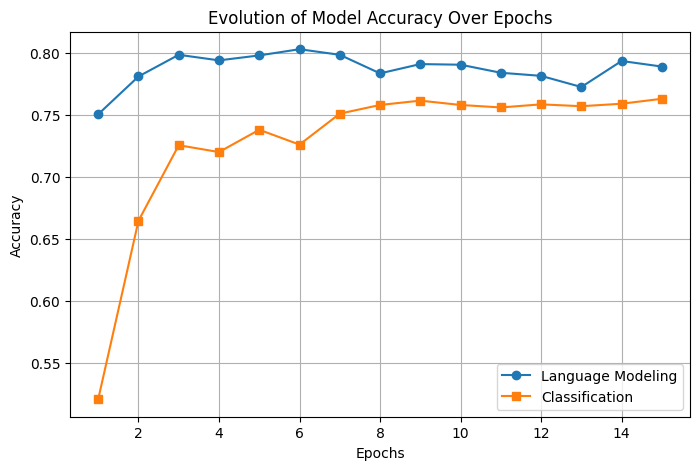

In [50]:
#Visualize the accuracy
import matplotlib.pyplot as plt

epochs = list(range(1, 16))

accuracy_language_modeling = pretrained_valid_acc
accuracy_classification = from_scratch_valid_acc

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy_language_modeling, marker='o', label="Language Modeling")
plt.plot(epochs, accuracy_classification, marker='s', label="Classification")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Evolution of Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 4 (4 points): </b><br>
Interpret the results.
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 4: </b><br>
Your answer here


The language modeling accuracy starts high (~0.75) and gradually improves, stabilizing around 0.80. This indicates that the model effectively learns word sequences and context over epochs. However, slight fluctuations suggest overfitting or sensitivity to certain patterns in the data.

The classification model starts with lower accuracy (~0.52) but improves rapidly within the first few epochs, reaching ~0.75. This sharp increase suggests that the model quickly captures discriminative features for classification but later plateaus, indicating that additional training provides diminishing returns
<hr style="border:10px solid green"> </hr>
</font></h4>


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 5 (4 points): </b><br>
What is one of the limitations of the language modeling objective used in this notebook, compared to the masked language model objective introduced in <a href="https://arxiv.org/abs/1810.04805" target="_blank">Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.</a><br>
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 5: </b><br>
Your answer here

One major limitation of the standard language modeling objective used in this notebook is that it trains the model in an auto-regressive fashion, meaning the model predicts the next word sequentially from left to right. This means it can only leverage past context when making predictions.

In contrast, the Masked Language Model (MLM) objective used in BERT allows the model to learn from both left and right context by randomly masking certain words in the input and predicting them using surrounding words. This makes MLM a bidirectional approach, capturing richer contextual relationships, leading to better performance in downstream NLP tasks such as classification, question answering, and named entity recognition.
<hr style="border:10px solid green"> </hr>
</font></h4>
